**J'utilise le jeu de données FashionMNIST, qui est plus complexe à classifier que MNIST (il regroupe différentes catégories de vêtements - chat GPT me le présente ainsi : "il est particulièrement intéressant car il offre un défi plus complexe que MNIST, avec des objets plus variés.", et l'expérience confirme ici les dires de chat GPT). J'en retiens uniquement les classes étiquetées 0 et 1 (manifestement il s'agit des T-Shirt et des pantalons).**

**L'entraînement "simple" sur les images non perturbées confirme la complexité de classification plus grande de ces images par rapport aux images MNIST.**

**Les résultats de l'attaque adverse sont plus radicaux encore que pour MNIST, puisque nous atteignons ici 100 % d'erreurs (contre 84 % pour MNIST...).**

**L'entraînement robuste donne des résultats bien moins bons, et surtout moins stables selon les itérations, que pour MNIST (à moins de dimminuer le pas du gradient).**

**L'ensemble de mes ajouts et commentaires dans le texte est en gras. Les éléments du texte d'origine que j'ai simplement conservés et traduits sont en caractères non gras.**

In [ ]:
### PREAMBLE
# Chapter 2 - linear models
# linear.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

##Classification binaire

Commençons par commencer par considérer le cas de la classification binaire, c'est-à-dire $k=2$ dans le réglage multi-classes que nous décrivions ci-dessus. Dans ce cas, plutôt que d'utiliser une perte d'entropie croisée multi-classes, nous allons adopter l'approche la plus courante et utiliser l'entropie croisée binaire, ou la perte logistique. Dans ce contexte, nous avons notre fonction d'hypothèse


\begin{equation}
h_\theta(x) = w^T x + b
\end{equation}


pour $\theta = \{w \in \mathbb{R}^n, b \in \mathbb{R}\}$, les étiquettes de classes $y \in \{+1,-1\}$, et la fonction de perte


\begin{equation}
\ell(h_\theta(x), y) = \log(1+\exp(-y\cdot h_\theta(x))) \equiv L(y \cdot h_\theta(x))
\end{equation}

où, pour plus de commodité, nous définissons ci-dessous la fonction $L(z) = \log(1+\exp(-z))$  que nous utiliserons pour discuter de la façon de résoudre les problèmes d'optimisation impliquant cette perte. La sémantique de cette configuration est que pour un point de données $x$, le classificateur prédit la classe $+1$ avec une probabilité

\begin{equation}
p(y=+1|x) = \frac{1}{1 + \exp(-h_\theta(x))}.
\end{equation}



### Résoudre le problème de maximisation interne

Revenons maintenant au problème d'optimisation robuste, et considérons le problème de maximisation intérieure, qui dans ce cas prend la forme

\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(w^T (x+\delta), y) \equiv \maximize_{\|\delta\| \leq \epsilon} L(y \cdot (w^T(x+\delta) + b)).
\end{equation}


Le point clé que nous devons faire ici est que dans ce contexte, il est en fait possible de résoudre exactement ce problème de maximisation interne. Pour montrer cela, tout d'abord, notez que le $L$ tel que nous l'avons décrit précédemment est une fonction scalaire qui diminue de façon monotone, et qui ressemble à la suivante:

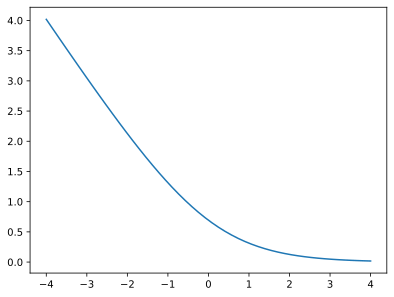

In [ ]:
x = np.linspace(-4,4)
plt.plot(x, np.log(1+np.exp(-x)))

Le problème de minmax devient, dans ce cas précis, un (simple) problème de minimisation (voir le chap2 sur le site en version anglaise, pour les détails de la démonstration) :

\begin{equation}
minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_* \right )
\end{equation}

qui ressemble énormément au problème régularisé par la norme, que nous considérons couramment dans l'apprentissage automatique.


\begin{equation}
minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L (y \cdot (w^Tx + b)) + \epsilon \|w\|_*
\end{equation}

sauf que le terme de régularisation est à l'intérieur de la fonction de perte. Intuitivement, cela signifie que dans le cas de l'optimisation robuste, si un point est éloigné de la limite de décision, nous ne pénalisons pas la norme des paramètres, mais nous pénalisons la norme des paramètres (transformé par la fonction de perte) pour un point où nous nous rapprochons de la limite de décision.

Les liens entre ces formulations et, par exemple, les SVM, ont été étudiés de manière approfondie.


### Illustration pour l'ajustage d'un modèle de classification binaire

Puisque nous sommes dans le cadre de la classification binaire pour l'instant, concentrons-nous sur le problèmede simplement classer entre 0 et 1 dans les données MNIST (nous reviendrons bientôt au réglage multi-classes pour les modèles linéaires). Chargeons d'abord les données en utilisant la bibliothèque PyTorch et construisons un classificateur linéaire simple en utilisant la descente de gradient. Nous allons le faire plus explicitement qu'en utilisant simplement les fonctions PyTorch dédiées.


**Chargons les données FashionMNIST, qui consistent en des vêtements à classer par catégories (T-Shirt, pantalon, etc), en lieu et place du jeu de données MNIST initial (chiffres de 1 à 10).**

**On ne garde que les catégories de vêtements ayant pour étiquettes y=0 ou y=1 (il s'agit manifestement des T-Shirt et des pantalons).**

In [ ]:
#jeu de données FashionMNIST

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# Use 'data' and 'targets' instead of 'train_data' and 'train_labels'
train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

#train_idx = mnist_train.train_labels <= 1
#mnist_train.train_data = mnist_train.train_data[train_idx]
#mnist_train.train_labels = mnist_train.train_labels[train_idx]

# Use 'data' and 'targets' instead of 'test_data' and 'test_labels'
test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

#test_idx = mnist_test.test_labels <= 1
#mnist_test.test_data = mnist_test.test_data[test_idx]
#mnist_test.test_labels = mnist_test.test_labels[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 334kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.24MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 12.8MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
#jeu de données d'origine du programme (MNIST) - ne pas utiliser ici puisqu'on fait tourner sur FashionMNIST

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

# Use 'data' and 'targets' instead of 'train_data' and 'train_labels'
train_idx = mnist_train.targets <= 1
mnist_train.data = mnist_train.data[train_idx]
mnist_train.targets = mnist_train.targets[train_idx]

#train_idx = mnist_train.train_labels <= 1
#mnist_train.train_data = mnist_train.train_data[train_idx]
#mnist_train.train_labels = mnist_train.train_labels[train_idx]

# Use 'data' and 'targets' instead of 'test_data' and 'test_labels'
test_idx = mnist_test.targets <= 1
mnist_test.data = mnist_test.data[test_idx]
mnist_test.targets = mnist_test.targets[test_idx]

#test_idx = mnist_test.test_labels <= 1
#mnist_test.test_data = mnist_test.test_data[test_idx]
#mnist_test.test_labels = mnist_test.test_labels[test_idx]

train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 94.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 17.9MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 88.8MB/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.77MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Construisons un classificateur linéaire simple (le module `nn.Linear` le fait, en contenant les poids dans l'objet `.weight` et le biais dans l'objet `.bias`). La fonction `nn.Softplus` implémente la $L$ fonction ci-dessus (sans annuler l'entrée), et le fait d'une manière plus stable numériquement que l'utilisation des fonctions exp ou log directement.


In [ ]:
import torch #module principal de PyTorch qui fournit des fonctions pour les tensors et des opérations mathématiques entre eux
import torch.nn as nn #Contient des outils pour créer des réseaux de neurones (couches, fonctions de perte, ...)
import torch.optim as optim #module qui fournit des optimisateurs pour ajuster les poids du modèle pendant l'entraînement

# do a single pass over the data - fonction qui calcule l'erreur et la perte pour toutes les données, en itérant sur les données par lots
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0]
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset) #et retourne le taux d'erreur moyen sur l'ensemble du jeu de données
        # (i.e le nombre d'erreurs divisé par le nombre total d'exemples dans le dataset), ainsi que la perte moyenne sur l'ensemble
        # du jeu de données (même remarque).

**Nous allons entraîner le classificateur pour 10 epoch.**
**Contrairement aux données MNIST, pour lesquelles la classification binaire MNIST 0/1 était un problème très facile, puisqu'après un passage de epoch, nous avions convergé à l'erreur de test finale (bien que la perte de test diminue toujours), pour notre jeu de données FashinMNIST, la convergence est effective à la 8e itération.**

In [ ]:
#entraînement d'un modèle simple avec une régression linéaire
#puis calcule des erreurs et pertes pour l'entraînement et le test à chaque passage de epoch().
#impression pour chaque itération.

model = nn.Linear(784, 1)
opt = optim.SGD(model.parameters(), lr=1.)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
for i in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.042250	0.332835	0.019500	0.061752
0.016917	0.055185	0.016000	0.050903
0.014667	0.043847	0.015000	0.042811
0.012667	0.040138	0.014500	0.039630
0.011750	0.036786	0.016000	0.039753
0.011000	0.034918	0.013000	0.035493
0.011250	0.033393	0.014000	0.036477
0.010833	0.032551	0.013500	0.036229
0.010167	0.030856	0.015000	0.037243
0.009250	0.029619	0.015000	0.036654


**Regardons un exemple de test sur lequel le classificateur fait une erreur (on affiche la première des images inexactement classées).**


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Text(0.5, 1.0, 'True Label: 1 Wrong label: -0.6701381206512451')

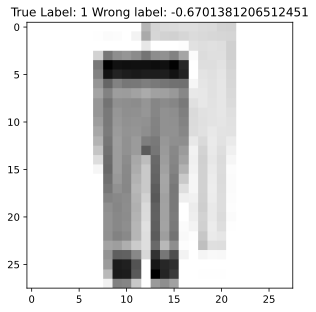

In [ ]:
X_test = (test_loader.dataset.test_data.float()/255).view(len(test_loader.dataset),-1)
y_test = test_loader.dataset.test_labels
yp = model(X_test)[:,0]
idx = (yp > 0) * (y_test == 0) + (yp < 0) * (y_test == 1)

# Ajout : Get the indices of the incorrectly classified images
incorrect_indices = idx.nonzero()

# Ajout : Get the first index where the condition in idx is True
first_incorrect_idx = idx.nonzero()[0].item()


plt.imshow(1-X_test[idx][0].view(28,28).numpy(), cmap="gray")
#plt.title("True Label: {}".format(y_test[idx].item())) modifié en :
#plt.title("True Label: {}".format(y_test[first_incorrect_idx].item()))
plt.title("True Label: {} Wrong label: {}".format(y_test[first_incorrect_idx].item(), yp[first_incorrect_idx].item())) #j'ajoute l'affichage de l'étiquette prédite


Dans le cas linéaire, la perturbation optimale est égale à

\begin{equation}
\delta^\star = - y \epsilon \cdot \mathrm{sign}(w),
\end{equation}

qui n'est pas dépendant de $x$, ce qui signifie que la meilleure perturbation à appliquer est la même pour tous les exemples.

Attention : pour obtenir la meilleure perturbation valide, nous devrons vraiment nous limiter à être dans $[0,1]$, ce qui n'est pas vérifié pour ce cas. Pour plus de simplicité, nous l'ignorerons pour l'instant, et nous  ajouterons donc ce même $\delta$ "coûte que coûte" (même si cela nous donne une image techniquement invalide).


Text(0.5, 1.0, 'visualisation du bruit :')

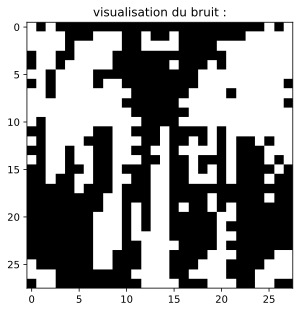

In [ ]:
#création d'une version "bruitée", "perturbée", de notre image
epsilon = 0.2 #ampleur du bruit créé
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")#affichage-visualisation de la perturbation
plt.title("visualisation du bruit :")

**Voyons ensuite ce qui se passe lorsque nous évaluons la précision du test une fois faite cette attaque adverse (optimale) sur les images dans l'ensemble de test.**


In [ ]:
def epoch_adv(loader, model, delta): #on ajoute delta parmi les paramètres...
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model((X-(2*y.float()[:,None,None,None]-1)*delta).view(X.shape[0], -1))[:,0] #A la différence de la fonction epoch, on retranche ici à X la quantité
                                                                                          #(2*y.float()[:,None,None,None]-1)*delta)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)
print(epoch_adv(test_loader, model, delta[None,None,:,:]))

(1.0, 15.551019382476806)


**Donc, en permettant des perturbations à l'intérieur de la boule $\ell_\infty$ de taille $\epsilon=0.2$, le classificateur nous passe d'une erreur quasi nulle à une erreur de 100% : c'est encore pire qu'avec MNIST.**


**Visualisons les images ainsi perturbées :**

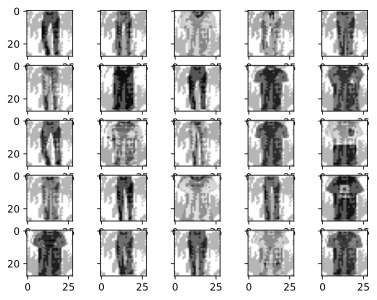

In [ ]:
f,ax = plt.subplots(5,5, sharey=True) #Crée une figure (f) avec une grille de sous-graphes (axes) ax de taille 5x5 (sharey=True indique que les axes des ordonnées
                                      #seront partagés entre tous les sous-graphes, ce qui signifie qu'ils auront les mêmes limites sur l'axe vertical.)
for i in range(25):
    ax[i%5][i//5].imshow(1-(X_test[i].view(28,28) - (2*y_test[i]-1)*delta).numpy(), cmap="gray")
    ax

### Entrainement d'un modèle linéaire robuste

Un modèle linéaire standard souffre de beaucoup de problèmes similaires aux modèles profonds.
Mais nous pouvons facilement réaliser une optimisation robuste exacte (c'est-à-dire résoudre l'équivalent du problème min-max) en incorporant simplement la norme $\ell_1$  dans l'objectif. En mettant cela dans la perte d'entropie croisée standard que PyTorch met en oeuvre (qui utilise des étiquettes de 0/1 par défaut, pas -1/1), cela nécessite un peu de manipulations, mais la procédure d'entraînement reste encore assez simple: on soustrait simplement $\epsilon(2y-1)\|w\|_1$ des prédictions (les $2y-1$ échelonnent les entrées 0/1 à -1/1).

In [ ]:
# do a single pass over the data
def epoch_robust(loader, model, epsilon, opt=None):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        yp = model(X.view(X.shape[0], -1))[:,0] - epsilon*(2*y.float()-1)*model.weight.norm(1) #on perturbe X par +/-epsilon*(norme des poids)
        loss = nn.BCEWithLogitsLoss()(yp, y.float())
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += ((yp > 0) * (y==0) + (yp < 0) * (y==1)).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [ ]:
#on augmente le nombre d'itérations à 100, par rapport au programme initial
model = nn.Linear(784, 1) #modèle linéaire simple avec PyTorch, qui prend un vecteur d'entrée de taille 784, et donne en sortie un unique score
                          #(donc c'est un modèle de classification binaire)
opt = optim.SGD(model.parameters(), lr=1e-1)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(100):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.582667	1.949771	0.566500	2.055249
0.575417	1.758976	0.558000	2.573468
0.570667	1.739572	0.637500	1.226148
0.563083	1.617311	0.571000	1.721281
0.564750	1.622069	0.564500	1.536296
0.553917	1.541743	0.454500	1.192850
0.542083	1.524004	0.486000	1.305395
0.523583	1.499077	0.336000	0.947225
0.546333	1.536858	0.480000	1.356996
0.524417	1.470110	0.600500	1.695939
0.522417	1.444726	0.300500	0.866669
0.505167	1.432746	0.476000	1.389010
0.512917	1.350514	0.555000	1.916547
0.522000	1.471989	0.609500	1.552760
0.510833	1.405303	0.610500	1.454929
0.531750	1.490730	0.615000	1.330832
0.464750	1.307620	0.620000	1.258157
0.519167	1.452680	0.330500	0.949150
0.494417	1.389547	0.614000	1.396320
0.522417	1.447224	0.608000	1.584764
0.492917	1.351675	0.436000	1.274400
0.480917	1.322868	0.553000	1.731360
0.496000	1.366383	0.478500	1.368238
0.487917	1.382275	0.554000	2.080195
0.498583	1.399839	0.527500	1.582239
0.492167	1.352458	0.602000	1.792713
0.52

In [ ]:
#On réduit, de plus, la taille du pas de gradient
model = nn.Linear(784, 1) #modèle linéaire simple avec PyTorch, qui prend un vecteur d'entrée de taille 784, et donne en sortie un unique score
                          #(donc c'est un modèle de classification binaire)
opt = optim.SGD(model.parameters(), lr=1e-2)
epsilon = 0.2
print("Rob. Train Err", "Rob. Train Loss", "Rob. Test Err", "Rob. Test Loss", sep="\t")
for i in range(100):
    train_err, train_loss = epoch_robust(train_loader, model, epsilon, opt)
    test_err, test_loss = epoch_robust(test_loader, model, epsilon)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Rob. Train Err	Rob. Train Loss	Rob. Test Err	Rob. Test Loss
0.686833	0.820920	0.569000	0.708182
0.621500	0.699314	0.642500	0.693013
0.624333	0.690480	0.606500	0.685141
0.607917	0.684263	0.631500	0.677851
0.582333	0.679639	0.624500	0.674474
0.524500	0.674700	0.477500	0.668078
0.469333	0.670857	0.475500	0.666274
0.391750	0.666728	0.356000	0.662918
0.357750	0.663547	0.326000	0.660387
0.319667	0.660580	0.299500	0.655070
0.311833	0.658045	0.300500	0.655047
0.304333	0.655697	0.307000	0.652307
0.297500	0.652795	0.289000	0.650312
0.297167	0.651303	0.293000	0.652410
0.293083	0.648869	0.288500	0.646377
0.292250	0.647230	0.291500	0.645525
0.290667	0.645329	0.287000	0.643010
0.286667	0.643687	0.281000	0.640021
0.287083	0.642883	0.281500	0.645083
0.286083	0.641443	0.281000	0.636510
0.285083	0.639882	0.278500	0.636779
0.283833	0.639025	0.278000	0.636400
0.281083	0.637525	0.277500	0.634673
0.284000	0.637672	0.277000	0.636643
0.281000	0.636521	0.274500	0.633426
0.281000	0.635861	0.277000	0.636786
0.27

**Les chiffres ci-dessus sont les erreurs et les pertes robustes. En s'entraînant avec le problème d'optimisation robuste, nous sommes en mesure de former un modèle tel que pour $\epsilon=0.2$, aucune attaque adverse ne puisse conduire à plus que 60% d'erreurs environ sur l'ensemble de test. C'est une bonne amélioration par rapport aux 100% d'erreur de l'entrainement standard, même si c'est bien moins bon que les de 2,5% d'erreurs obtenus sur le jeu de données MNIST via ce même entraînement robuste.**


**On constate en outre que même au bout de 100 itérations, l'erreur oscille toujours entre 60% et 30% environ, alors que pour MNIST elle se stabilisait dès la première vingtaine d'itérations : nos vêtements à la mode sont plus difficiles à protéger des attaques adverses !**

**Pour parvenir à cette stabilisation pour notre nouveau jeu de données, il faut, en plus, réduire la longueur du pas de gradient (ainsi on n'a plus les oscillations, mais une convergence du taux d'erreur - autour de 0.26).**

**Mais dans quelle mesure procède, maintenant, cet entraînement robuste sur le training set non adverse : ses performances seront-elles équivalentes ou inférieures à l'entraînement standard ?**


In [ ]:
train_err, train_loss = epoch(train_loader, model)
test_err, test_loss = epoch(test_loader, model)
print("Train Err", "Train Loss", "Test Err", "Test Loss", sep="\t")
print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

Train Err	Train Loss	Test Err	Test Loss
0.072833	0.187365	0.074500	0.194970


**Nous obtenons 7,45 % d'erreur sur l'essai, contre 1,5 % d'erreur avec l'entraînement standard : tout comme pour MNIST, l'erreur avec l'entraînement robuste est supérieure à celle issue de l'entraînement standard. Ceci confirme qu'il existe un compromis fondamental entre une précision "propre" et une précision "robuste", et que faire mieux sur l'erreur robuste conduit à une plus grande erreur "propre".**

**Regardons l'image de la perturbation optimale pour ce modèle robuste.**


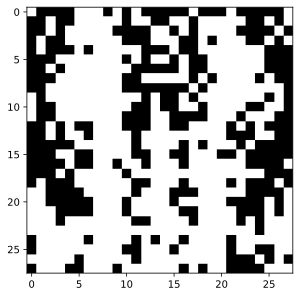

In [ ]:
delta = epsilon * model.weight.detach().sign().view(28,28)
plt.imshow(1-delta.numpy(), cmap="gray")

**Cela prend beaucoup plus de directions verticales (comme un T-Shirt ou un pantalon) que ce que nous avons vu auparavant. Ainsi, nous avons (à ce stade, certes, à un point assez faible) des preuves que l'entrainement robuste peut aussi conduire à des « directions adverses » qui sont intrinsèquement plus significatives. Plutôt que de tromper le classificateur en ajoutant simplement du « bruit aléatoire », nous devons en fait commencer à déplacer l'image dans la direction d'une nouvelle image réelle.**



## Classification multi-classe

Contrairement au cas binaire, le problème de minmax ne peut être résolu de manière exacte (détails dans le chapitre 2 sur le site internet).